### Loading Necessary Libraries

In [4]:
#from kats.models.prophet import ProphetModel, ProphetParams
#from kats.consts import TimeSeriesData
#from kats.models.var import VARModel, VARParams
import pandas as pd

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

### Read in Data

In [49]:
# read all files from a directory
path = r'/Users/edawg/Desktop/Duke/Time Series/Heart-Rate-Variability-Repo/01_data/1st topic'
rri_files = glob.glob(os.path.join(path, "*_RRI.txt"))
all_patients_df = pd.DataFrame()

for i in range(len(rri_files)):
    patient = rri_files[i].split("/")[-1][0:-8]
    bis_path = path + "/" + patient + "_BIS.txt"
    patient_num = i + 1

    # read in the data
    rri = pd.read_table(rri_files[i], sep=",",names=["time","signal"])
    bis = pd.read_table(bis_path, sep=",",names=["time","signal"])

    # rename signal column
    rri.rename(columns={"signal": "rri_" + str(patient_num)}, inplace=True)
    bis.rename(columns={"signal": "bis_" + str(patient_num)}, inplace=True)

    # merge the data
    patient_df = pd.concat([rri['rri_' + str(patient_num)], bis['bis_' + str(patient_num)]], axis=1)
    all_patients_df = pd.concat([all_patients_df, patient_df], axis=1)

all_patients_df['time'] = all_patients_df.index
all_patients_df['pre_post'] = np.where(all_patients_df['time']<all_patients_df['time'][1440],0,1)
all_patients_df

,rri_1,bis_1,rri_2,bis_2,rri_3,bis_3,rri_4,bis_4,rri_5,bis_5,...,rri_25,bis_25,rri_26,bis_26,rri_27,bis_27,rri_28,bis_28,time,pre_post
0,825.896112,56.164708,859.940135,43.098800,1055.712962,45.324064,656.771280,26.826689,964.467668,32.516983,...,731.866074,32.772420,844.174638,48.706720,1036.769300,37.528583,1104.571104,30.087002,0,0
1,825.899059,56.254664,858.098369,43.013895,1053.145867,45.194152,658.444182,26.801709,966.577226,32.432015,...,731.782331,32.817382,842.900578,48.786638,1040.097782,37.493595,1093.828273,30.111988,1,0
2,826.375276,56.344620,856.832234,42.928991,1049.441234,45.064240,660.013387,26.683644,967.880418,32.347048,...,730.477343,32.862344,844.835599,48.866557,1042.938552,37.458607,1084.926249,30.136973,2,0
3,827.648728,56.428813,856.646906,42.844087,1045.467821,44.934327,661.246011,26.558743,968.716328,32.262080,...,728.749676,32.907305,848.612716,48.946475,1043.992788,37.423619,1080.409352,30.161959,3,0
4,829.692027,56.503777,858.001085,42.759182,1042.094387,44.933087,661.966394,26.433842,969.476936,32.177112,...,727.435389,32.952267,852.054107,49.026393,1042.490969,37.388631,1081.227743,30.186945,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3836,739.525796,46.015123,953.255002,40.131617,852.841400,35.353787,636.117628,2.100000,762.074342,28.416510,...,871.426323,40.124091,1168.519256,57.236577,765.351208,29.514652,878.304499,33.118502,3836,1
3837,738.431676,46.025118,958.937697,40.011752,853.109321,35.378770,636.779477,2.100000,762.639833,28.411512,...,875.308250,40.049155,1167.405411,57.466343,764.515831,29.479664,883.227917,33.008565,3837,1
3838,737.117124,46.035113,961.489002,39.891887,853.377243,35.403753,637.647817,2.100000,763.976446,28.406514,...,878.991623,39.974219,1166.291567,57.562392,757.284474,29.444676,886.297960,32.898627,3838,1
3839,735.944230,46.045108,962.656826,39.772022,853.645164,35.428737,638.777592,2.100000,766.311931,28.401516,...,879.795025,39.899283,1165.177722,57.472484,748.945789,29.409688,887.585408,32.788690,3839,1


### Data Exploration

In [72]:
rris = all_patients_df[[col for col in all_patients_df if col.startswith('rri')]].copy()
rris['time'] = all_patients_df['time']
bis_all = all_patients_df[[col for col in all_patients_df if col.startswith('bis')]].copy()
bis_all['time'] = all_patients_df['time']

Plotting RRI data for all 28 patients

In [78]:
rris['rri_9'].isnull().sum()

0

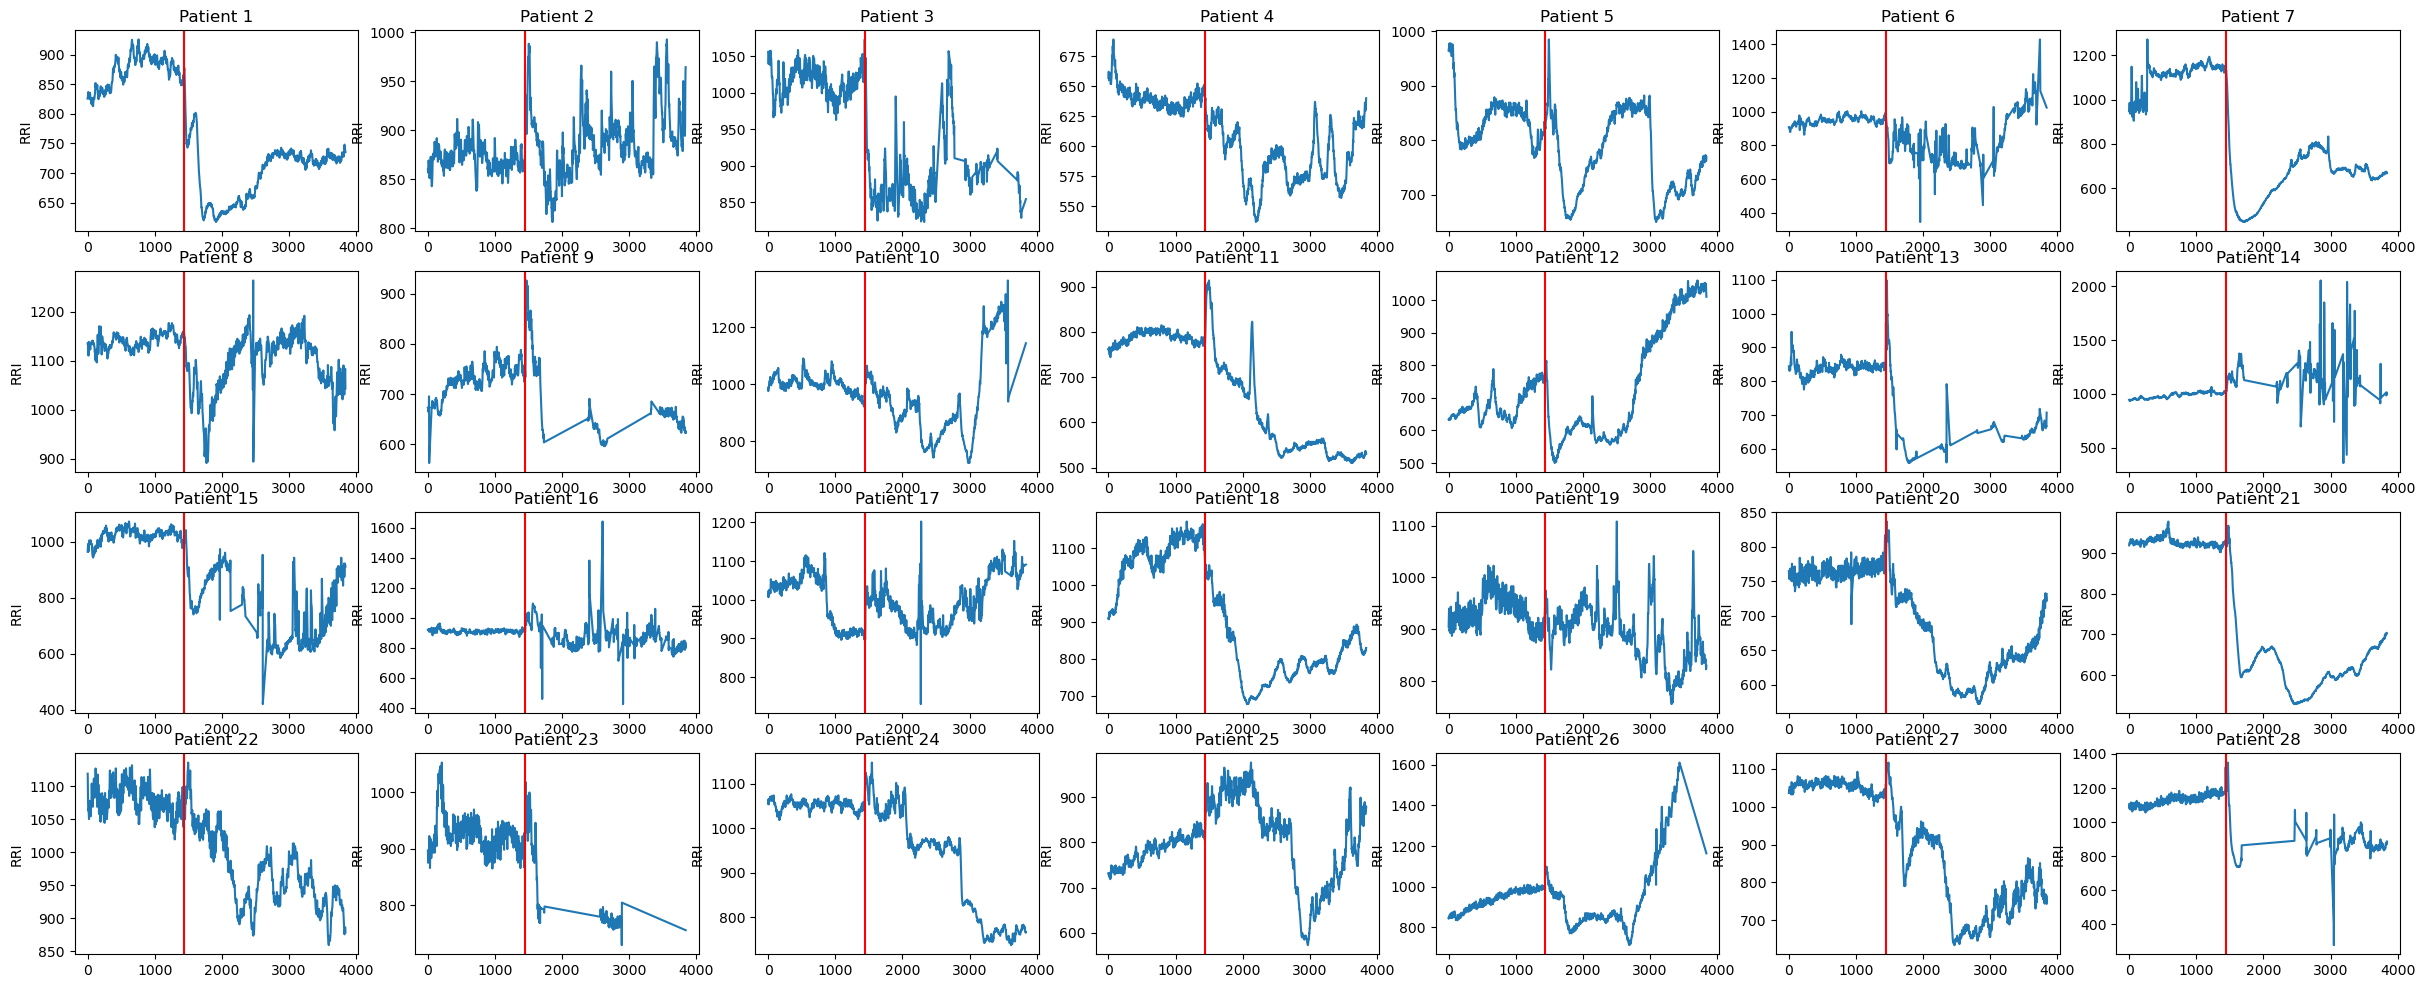

In [73]:
fig, axs = plt.subplots(4, 7, figsize=(30, 12))

for i in range(4):
    for j in range(7):
        axs[i,j].plot(rris['time'], rris["rri_" + str(i*7+j+1)])
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('RRI')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')

Plotting BIS data for all 28 patients:

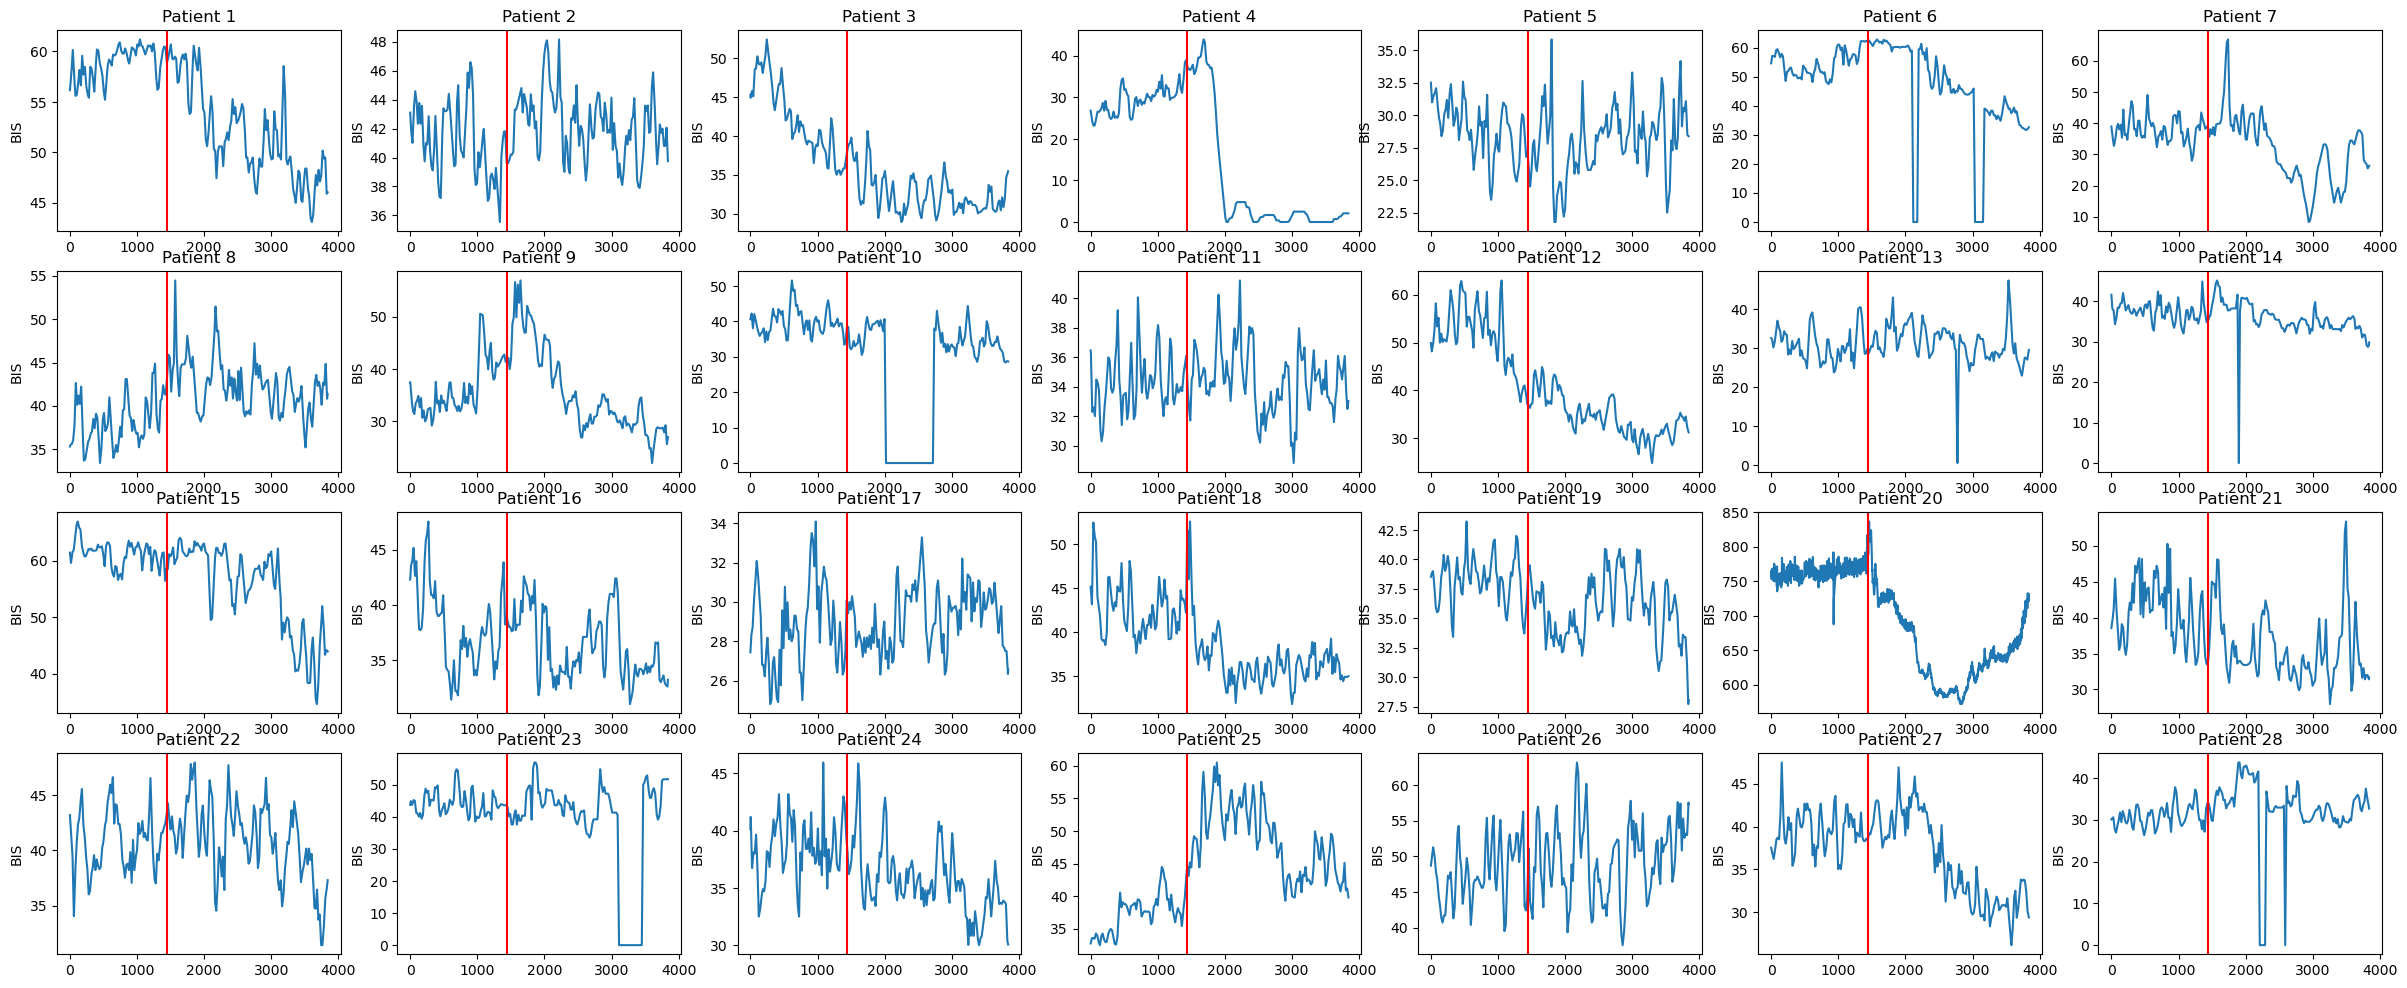

In [75]:
fig, axs = plt.subplots(4, 7, figsize=(30, 12))

for i in range(4):
    for j in range(7):
        axs[i,j].plot(bis_all['time'], bis_all["bis_" + str(i*7+j+1)])
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('BIS')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')

In [70]:
#calculate ADFs for each
# calculate mean times

### Data Preprocessing

1) If we don't have any 0s in the RRI data how do we identify missing data?

- Differencing
- Smoothing
- SST?? What does this do??
- What to do with huge jumps?
- imputing [x] done

In [102]:
rris['rri_1'].diff()

0            NaN
1       0.002947
2       0.476217
3       1.273452
4       2.043299
          ...   
3836   -0.490949
3837   -1.094119
3838   -1.314552
3839   -1.172894
3840   -0.780122
Name: rri_1, Length: 3841, dtype: float64

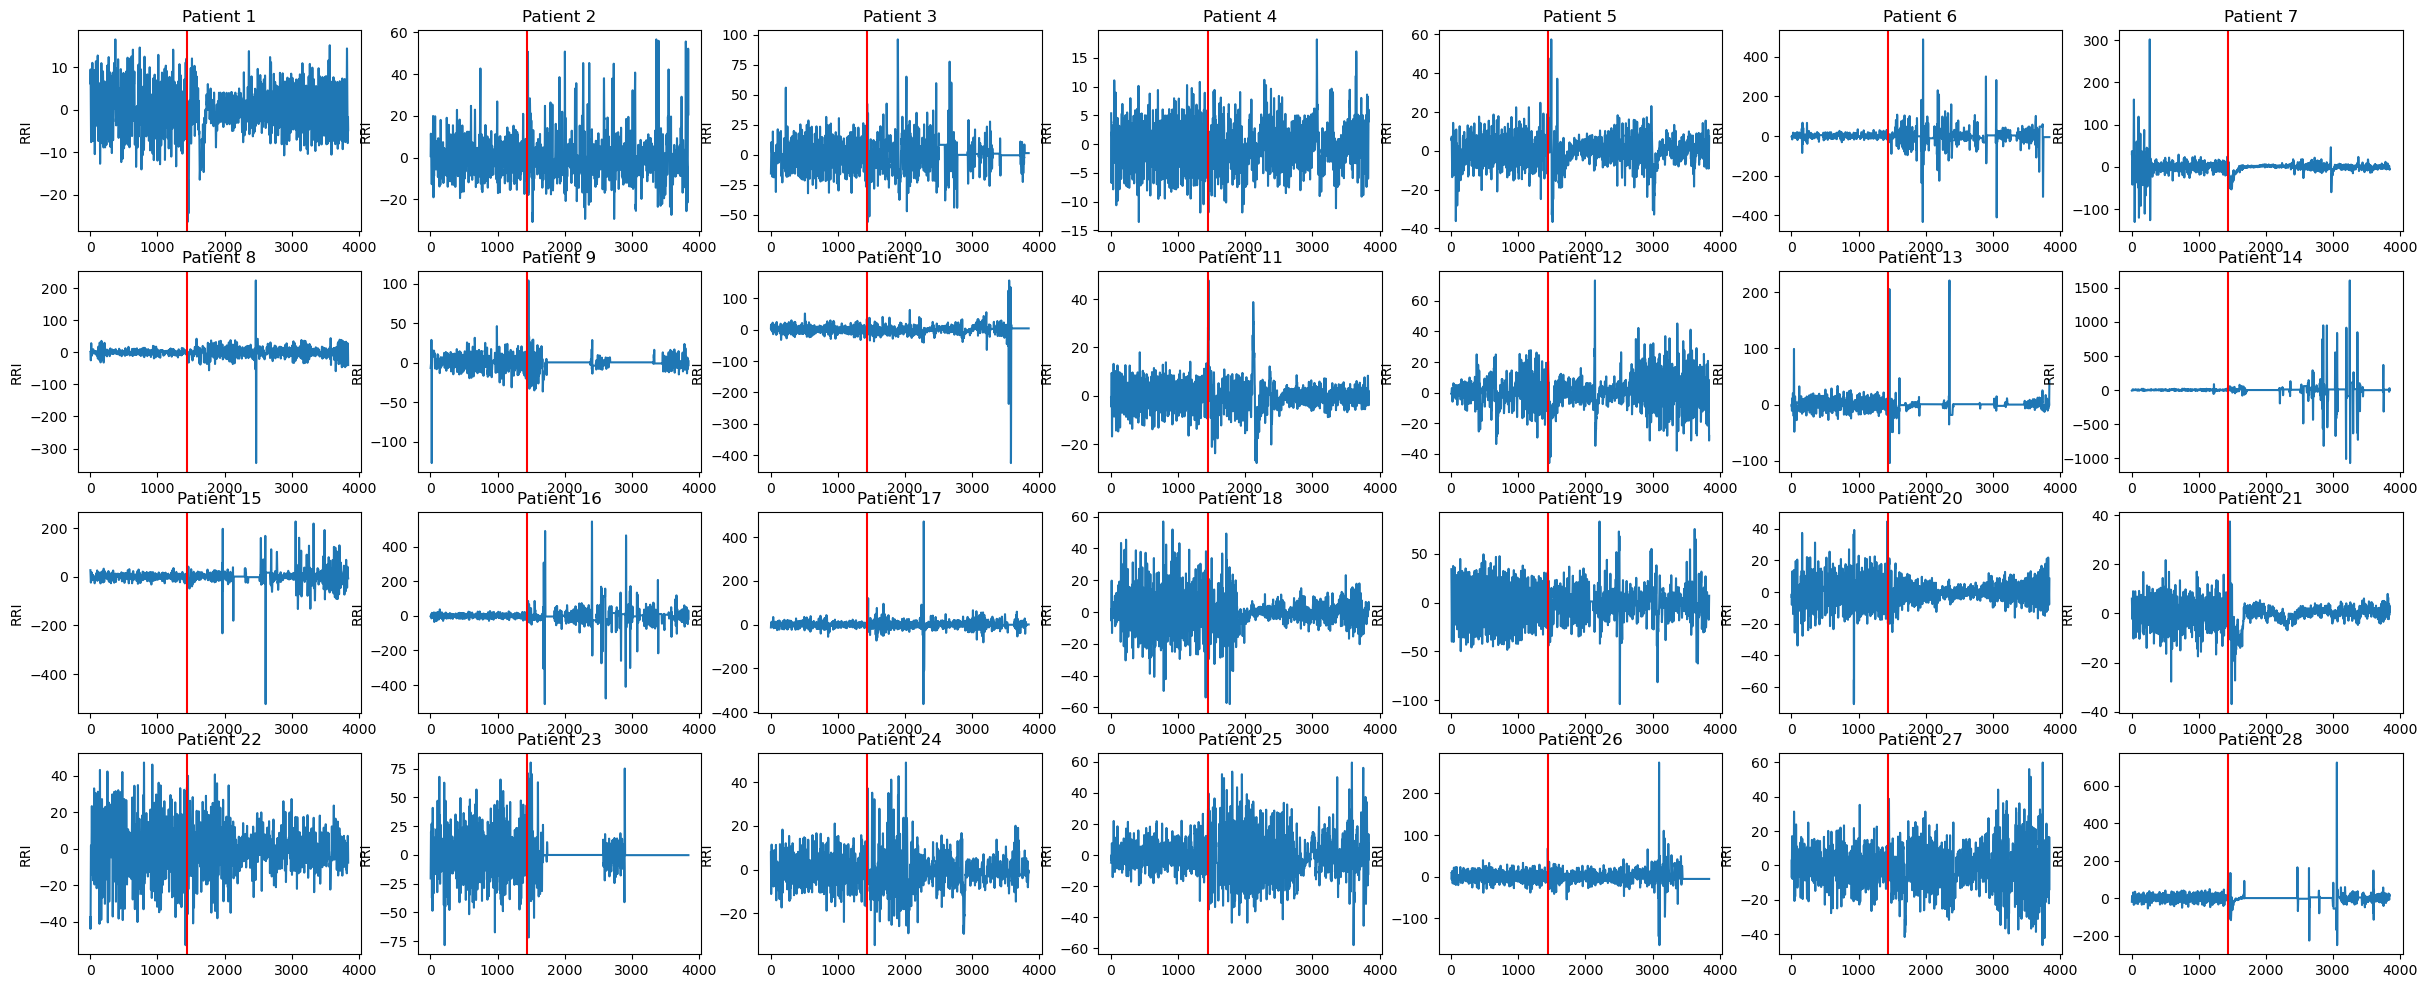

In [116]:
# plot the differences

fig, axs = plt.subplots(4, 7, figsize=(30, 12))

for i in range(4):
    for j in range(7):
        axs[i,j].plot(rris['time'], rris["rri_" + str(i*7+j+1)].diff(periods = 5))
        axs[i,j].set_title('Patient ' + str(i*7+j+1))
        axs[i,j].set_ylabel('RRI')
        axs[i, j].axvline(x = 1440, color = 'r', label = 'axvline - full height')


### Hyperparameter Tuning